# Matryoshka Representation Learning (MRL) for Efficient Text Classification

## Overview
This notebook demonstrates Matryoshka Representation Learning (MRL), a technique that creates nested embeddings of varying dimensions. MRL enables a single model to operate at multiple efficiency-accuracy trade-off points without retraining.

## Business Value
- **Cost Efficiency**: Deploy the same model at different dimensions based on resource constraints
- **Deployment Flexibility**: Switch between high-accuracy and low-latency configurations
- **Storage Optimization**: Save storage costs with smaller embeddings when appropriate
- **Progressive Loading**: Load only what you need in resource-constrained environments

In [1]:
# Data processing and scientific computing
import numpy as np
import time

# Machine learning libraries
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

# Deep learning framework
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Visualization
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 2. Data Loading and Preparation

We'll use a subset of the 20 Newsgroups dataset, which contains text documents from various newsgroups. This serves as our example NLP classification task.

In [2]:
def load_and_prepare_data():
    """Load, preprocess, and split the text classification dataset.

    Returns:
        tuple: Training and testing data splits (X_train, X_test, y_train, y_test)
    """
    # Select a subset of categories for our classification task
    categories = ['rec.autos', 'comp.graphics', 'sci.med', 'rec.sport.baseball']

    # Load the dataset, removing headers, footers, and quotes to focus on content
    newsgroups = fetch_20newsgroups(
        subset='all',
        categories=categories,
        remove=('headers', 'footers', 'quotes')
    )

    X, y = newsgroups.data, newsgroups.target

    # Split into training (80%) and testing (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    print(f"Loaded {len(X_train)} training and {len(X_test)} testing documents")
    print(f"Number of classes: {len(categories)}")

    return X_train, X_test, y_train, y_test

# Load the text dataset
X_train, X_test, y_train, y_test = load_and_prepare_data()

Loaded 3157 training and 790 testing documents
Number of classes: 4


## 3. Feature Extraction with TF-IDF

We'll convert the raw text into TF-IDF vectors, which will serve as our initial high-dimensional representation.

In [3]:
def create_text_features(X_train, X_test, max_features=2000):
    """Convert text data to TF-IDF feature vectors.

    Args:
        X_train (list): Training text documents
        X_test (list): Testing text documents
        max_features (int): Maximum number of features to extract

    Returns:
        tuple: TF-IDF vectors and their tensor representations
    """
    # Create a TF-IDF vectorizer with a limited vocabulary size
    vectorizer = TfidfVectorizer(max_features=max_features)

    # Fit on training data and transform both training and testing data
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Convert sparse matrices to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_tfidf.toarray())
    X_test_tensor = torch.FloatTensor(X_test_tfidf.toarray())
    y_train_tensor = torch.LongTensor(y_train)
    y_test_tensor = torch.LongTensor(y_test)

    print(f"Created {X_train_tfidf.shape[1]} TF-IDF features")

    return {
        'vectorizer': vectorizer,
        'X_train_tfidf': X_train_tfidf,
        'X_test_tfidf': X_test_tfidf,
        'X_train_tensor': X_train_tensor,
        'X_test_tensor': X_test_tensor,
        'y_train_tensor': y_train_tensor,
        'y_test_tensor': y_test_tensor
    }

# Create TF-IDF features
features = create_text_features(X_train, X_test)

Created 2000 TF-IDF features


## 4. Matryoshka Representation Learning Architecture

The core of MRL is an encoder that creates nested embeddings. Smaller embeddings are designed to be subsets of larger ones, allowing the model to operate at different dimensions without retraining.

In [4]:
class MRLEncoder(nn.Module):
    """Matryoshka Representation Learning encoder that creates nested embeddings.

    MRL creates a hierarchy of embeddings where smaller representations are
    subsets of larger ones. This enables a single model to operate at
    multiple efficiency points without retraining.
    """

    def __init__(self, input_dim, max_dim=768):
        """Initialize the MRL encoder.

        Args:
            input_dim (int): Dimension of the input features
            max_dim (int): Maximum embedding dimension
        """
        super(MRLEncoder, self).__init__()
        self.max_dim = max_dim

        # Main encoder that produces the full-dimensional embedding
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, max_dim)
        )

        # Define nested dimensions from smallest to largest
        self.nested_dims = [32, 64, 128, 256, 512, max_dim]

        # Projection layers to ensure embeddings are properly structured
        # Each dimension has its own projection from the full embedding
        self.projections = nn.ModuleDict()
        for dim in self.nested_dims:
            self.projections[str(dim)] = nn.Linear(max_dim, dim, bias=False)

        # Initialize projections to create nested subspaces
        self._initialize_nested_projections()

    def _initialize_nested_projections(self):
        """Initialize projection matrices to ensure nested embeddings property.

        In MRL, smaller embeddings should be subsets of larger ones.
        This initialization ensures that the first N dimensions of a larger
        embedding match the N dimensions of a smaller embedding.
        """
        with torch.no_grad():
            for i, dim1 in enumerate(self.nested_dims[:-1]):
                dim2 = self.nested_dims[i+1]
                # Initialize so that projection to dim1 is equivalent to:
                # 1. Projecting to dim2
                # 2. Then taking the first dim1 dimensions
                self.projections[str(dim1)].weight.data = \
                    self.projections[str(dim2)].weight.data[:dim1, :]

    def forward(self, x, dim=None):
        """Generate embeddings at the specified dimension.

        Args:
            x (Tensor): Input features
            dim (int, optional): Requested embedding dimension

        Returns:
            Tensor: Embeddings at the requested dimension
        """
        # First get the full-dimensional embedding
        full_emb = self.encoder(x)

        # Return full embedding if no specific dimension requested
        if dim is None or dim == self.max_dim:
            return full_emb

        # Return the embedding at the requested dimension
        if str(dim) in self.projections:
            return self.projections[str(dim)](full_emb)
        else:
            # If exact dimension not available, take the first 'dim' dimensions
            return full_emb[:, :dim]

## 5. Classification Model with MRL Embeddings

Now we'll create a classifier that uses the MRL embeddings. This model can perform classification at different embedding dimensions, demonstrating the flexibility of MRL.

In [5]:
class MRLClassifier(nn.Module):
    """Classification model that uses Matryoshka Representation Learning.

    This classifier can operate at multiple embedding dimensions,
    allowing for flexible deployment based on resource constraints.
    """

    def __init__(self, input_dim, num_classes, max_dim=768):
        """Initialize the MRL classifier.

        Args:
            input_dim (int): Dimension of input features
            num_classes (int): Number of classification classes
            max_dim (int): Maximum embedding dimension
        """
        super(MRLClassifier, self).__init__()

        # Create the MRL encoder
        self.encoder = MRLEncoder(input_dim, max_dim)

        # Create classifiers for different embedding dimensions
        self.classifiers = nn.ModuleDict()
        for dim in self.encoder.nested_dims:
            self.classifiers[str(dim)] = nn.Linear(dim, num_classes)

    def forward(self, x, dim=None):
        """Perform classification using embeddings of the specified dimension.

        Args:
            x (Tensor): Input features
            dim (int, optional): Embedding dimension to use

        Returns:
            Tensor: Classification logits
        """
        # Default to maximum dimension if none specified
        if dim is None:
            dim = self.encoder.max_dim

        # Get the embeddings at specified dimension
        emb = self.encoder(x, dim)

        # Apply the appropriate classifier
        if str(dim) in self.classifiers:
            return self.classifiers[str(dim)](emb)
        else:
            # For dimensions not explicitly defined, use nearest smaller classifier
            dims = sorted([int(d) for d in self.classifiers.keys()])
            nearest = max([d for d in dims if d <= dim])
            return self.classifiers[str(nearest)](emb[:, :nearest])

def create_and_initialize_model(input_dim, num_classes):
    """Create and initialize the MRL classification model.

    Args:
        input_dim (int): Dimension of input features
        num_classes (int): Number of classification classes

    Returns:
        MRLClassifier: Initialized model
    """
    model = MRLClassifier(input_dim, num_classes)
    print(f"Created MRL classifier with maximum dimension {model.encoder.max_dim}")
    print(f"Available dimensions: {model.encoder.nested_dims}")
    return model

# Initialize the model
input_dim = features['X_train_tfidf'].shape[1]
num_classes = len(np.unique(y_train))
model = create_and_initialize_model(input_dim, num_classes)

Created MRL classifier with maximum dimension 768
Available dimensions: [32, 64, 128, 256, 512, 768]


## 6. Model Training

We'll train the model to create effective embeddings at all dimensions simultaneously. This multi-dimension training is key to MRL's flexibility.

In [6]:
def train_mrl_model(model, features, num_epochs=5, batch_size=64, learning_rate=0.001):
    """Train the MRL model at multiple dimensions simultaneously.

    Args:
        model (MRLClassifier): The model to train
        features (dict): Dictionary containing training data tensors
        num_epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        learning_rate (float): Learning rate for optimization

    Returns:
        MRLClassifier: Trained model
    """
    # Prepare data loader for batched training
    train_dataset = TensorDataset(features['X_train_tensor'], features['y_train_tensor'])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    print(f"\nTraining for {num_epochs} epochs with batch size {batch_size}...")
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        train_loss = 0
        batch_count = 0

        for batch_X, batch_y in train_loader:
            # Train with different dimensions in each batch
            for dim in model.encoder.nested_dims:
                optimizer.zero_grad()  # Clear gradients

                # Forward pass at current dimension
                outputs = model(batch_X, dim)

                # Compute loss and backpropagate
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            batch_count += 1

        # Calculate average loss for this epoch
        avg_loss = train_loss / (batch_count * len(model.encoder.nested_dims))
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    print("Training complete!")
    return model

# Train the model
model = train_mrl_model(model, features)


Training for 5 epochs with batch size 64...
Epoch 1/5, Loss: 0.4295
Epoch 2/5, Loss: 0.0940
Epoch 3/5, Loss: 0.0607
Epoch 4/5, Loss: 0.0562
Epoch 5/5, Loss: 0.0569
Training complete!


## 7. Model Evaluation

Now we'll evaluate the model's performance at different embedding dimensions to see the trade-offs between accuracy, inference time, and storage requirements.

In [7]:
def evaluate_model_at_multiple_dimensions(model, X_test_tensor, y_test):
    """Evaluate model performance at different embedding dimensions.

    Args:
        model (MRLClassifier): Trained model to evaluate
        X_test_tensor (Tensor): Test features
        y_test (array): Test labels

    Returns:
        list: Results for each dimension
    """
    model.eval()  # Set model to evaluation mode
    dims_to_evaluate = model.encoder.nested_dims
    results = []

    print("\nEvaluating performance at different dimensions:")
    print("----------------------------------------------------------------")
    print("Dimension | Accuracy | Inference Time (ms) | Storage Size (KB)")
    print("----------------------------------------------------------------")

    for dim in dims_to_evaluate:
        # Measure inference time
        start_time = time.time()
        with torch.no_grad():
            outputs = model(X_test_tensor, dim)
            _, predicted = torch.max(outputs, 1)
        inference_time = (time.time() - start_time) * 1000  # Convert to milliseconds

        # Calculate accuracy
        accuracy = accuracy_score(y_test, predicted.numpy())

        # Calculate storage requirements (in KB)
        # Assuming 4 bytes per float (32-bit floating point)
        storage_kb = (dim * 4) / 1024

        # Store results
        results.append({
            'dimension': dim,
            'accuracy': accuracy,
            'inference_time': inference_time,
            'storage_kb': storage_kb
        })

        print(f"{dim:9d} | {accuracy:.4f} | {inference_time:17.2f} | {storage_kb:15.2f}")

    print("----------------------------------------------------------------")
    return results

# Evaluate the model at different dimensions
results = evaluate_model_at_multiple_dimensions(
    model,
    features['X_test_tensor'],
    y_test
)


Evaluating performance at different dimensions:
----------------------------------------------------------------
Dimension | Accuracy | Inference Time (ms) | Storage Size (KB)
----------------------------------------------------------------
       32 | 0.8620 |            182.52 |            0.12
       64 | 0.8620 |            117.34 |            0.25
      128 | 0.8658 |            109.79 |            0.50
      256 | 0.8658 |            115.63 |            1.00
      512 | 0.8633 |            142.29 |            2.00
      768 | 0.8671 |             72.84 |            3.00
----------------------------------------------------------------


## 8. Visualizing Efficiency-Accuracy Trade-offs

Let's visualize the trade-offs between embedding dimension, accuracy, and storage requirements.

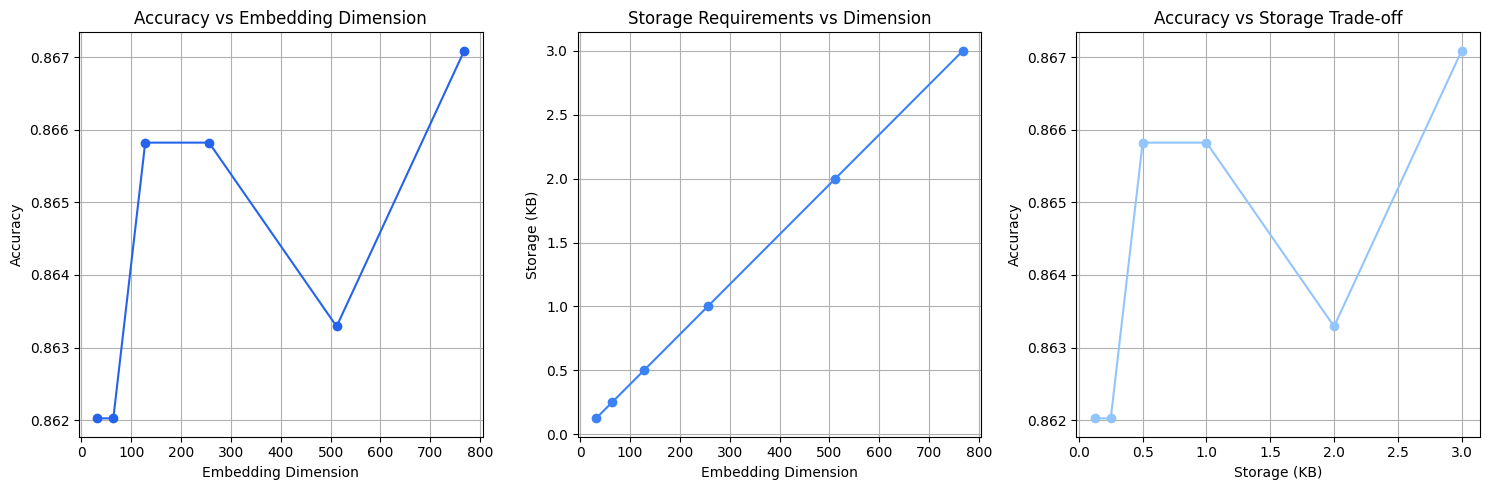

In [8]:
def visualize_tradeoffs(results):
    """Visualize the efficiency-accuracy trade-offs of MRL.

    Args:
        results (list): Evaluation results at different dimensions
    """
    plt.figure(figsize=(15, 5))

    # Plot accuracy vs dimension
    plt.subplot(1, 3, 1)
    plt.plot([r['dimension'] for r in results], [r['accuracy'] for r in results], 'o-', color='#2563EB')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Embedding Dimension')
    plt.grid(True)

    # Plot storage vs dimension
    plt.subplot(1, 3, 2)
    plt.plot([r['dimension'] for r in results], [r['storage_kb'] for r in results], 'o-', color='#3B82F6')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Storage (KB)')
    plt.title('Storage Requirements vs Dimension')
    plt.grid(True)

    # Plot accuracy vs storage
    plt.subplot(1, 3, 3)
    plt.plot([r['storage_kb'] for r in results], [r['accuracy'] for r in results], 'o-', color='#93C5FD')
    plt.xlabel('Storage (KB)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Storage Trade-off')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('mrl_tradeoff.png')
    plt.show()

# Visualize the trade-offs
visualize_tradeoffs(results)

## 9. Visualizing Embedding Structures with t-SNE

To better understand how MRL works, let's visualize the structure of embeddings at different dimensions using t-SNE.

Applying t-SNE to 32-dimensional embeddings...
Applying t-SNE to 768-dimensional embeddings...


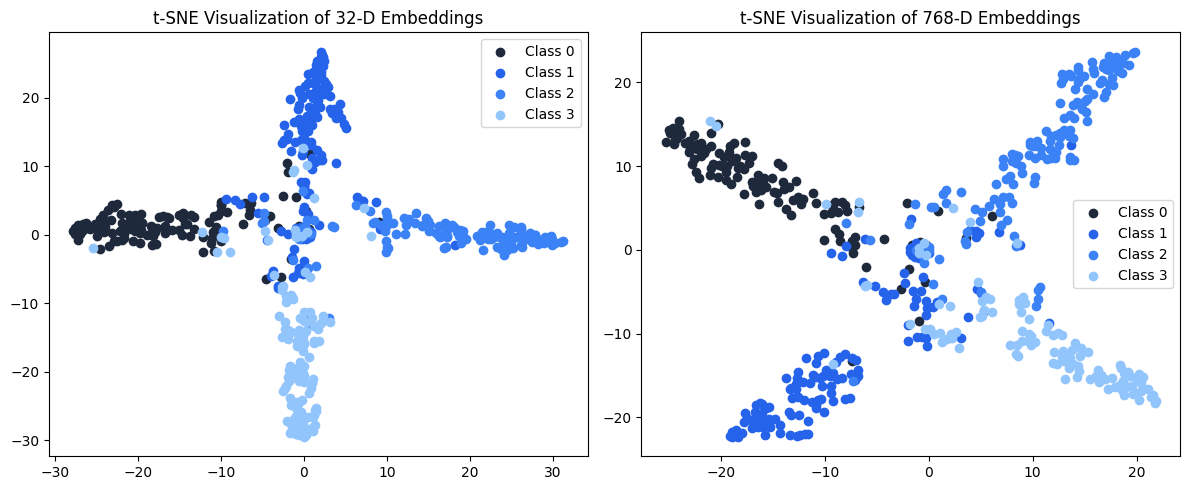

In [9]:
def visualize_embeddings_with_tsne(model, X_test_tensor, y_test, num_classes):
    """Visualize embedding structure at different dimensions using t-SNE.

    Args:
        model (MRLClassifier): Trained model
        X_test_tensor (Tensor): Test features
        y_test (array): Test labels
        num_classes (int): Number of classes
    """
    # Get embeddings at smallest and largest dimensions
    smallest_dim = model.encoder.nested_dims[0]
    largest_dim = model.encoder.nested_dims[-1]
    dims_to_visualize = [smallest_dim, largest_dim]

    # Extract embeddings at each dimension
    all_embeddings = {}
    with torch.no_grad():
        for dim in dims_to_visualize:
            embeddings = model.encoder(X_test_tensor, dim).numpy()
            all_embeddings[dim] = embeddings

    # Apply t-SNE to reduce to 2D for visualization
    tsne_results = {}
    for dim, emb in all_embeddings.items():
        # For speed, use a sample of the test set if it's large
        max_samples = 500
        if len(emb) > max_samples:
            sample_indices = np.random.choice(len(emb), max_samples, replace=False)
            sample_embeddings = emb[sample_indices]
            sample_labels = y_test[sample_indices]
        else:
            sample_embeddings = emb
            sample_labels = y_test

        print(f"Applying t-SNE to {dim}-dimensional embeddings...")
        tsne = TSNE(n_components=2, random_state=42)
        tsne_result = tsne.fit_transform(sample_embeddings)
        tsne_results[dim] = (tsne_result, sample_labels)

    # Plot t-SNE visualizations
    plt.figure(figsize=(12, 5))
    class_colors = ['#1E293B', '#2563EB', '#3B82F6', '#93C5FD']

    for i, dim in enumerate(dims_to_visualize):
        plt.subplot(1, 2, i+1)
        tsne_result, labels = tsne_results[dim]

        # Plot each class with a different color from brand palette
        for class_idx in range(num_classes):
            mask = labels == class_idx
            color = class_colors[class_idx % len(class_colors)]
            plt.scatter(
                tsne_result[mask, 0],
                tsne_result[mask, 1],
                color=color,
                label=f'Class {class_idx}'
            )

        plt.title(f't-SNE Visualization of {dim}-D Embeddings')
        plt.legend()

    plt.tight_layout()
    plt.savefig('mrl_tsne.png')
    plt.show()

# Visualize embeddings
visualize_embeddings_with_tsne(model, features['X_test_tensor'], y_test, num_classes)

## 10. Business Implications and Conclusions

### Key Findings
From the results above, we can derive several key insights about Matryoshka Representation Learning:

1. **Accuracy-Efficiency Spectrum**: MRL allows deploying the same model at different dimensions based on accuracy and efficiency needs.
2. **Deployment Flexibility**: Organizations can make real-time decisions about dimension tradeoffs without retraining models.
3. **Progressive Loading**: In bandwidth-constrained environments, smaller embeddings can be loaded first and expanded as needed.

### Business Applications

For engineering leaders and CTOs:
- **Cost Optimization**: Deploy smaller embeddings on edge devices or in high-volume applications to reduce infrastructure costs
- **Performance Tuning**: Adjust dimensions based on latency requirements without maintaining multiple models
- **Graceful Degradation**: Applications can fall back to smaller embeddings under heavy load

For product managers:
- **Feature Tiering**: Different product tiers can use different embedding dimensions
- **A/B Testing**: Test different dimensions to find optimal accuracy-cost balance
- **Progressive Enhancement**: Start with smaller embeddings and enhance as users engage more deeply

### Next Steps

1. **Scale Testing**: Apply MRL to larger models and datasets
2. **Production Implementation**: Integrate dynamic dimension selection in deployment pipelines
3. **Extended Benchmarking**: Measure impact on actual infrastructure costs
4. **Domain Adaptation**: Test MRL in domain-specific applications

MRL provides a valuable technique for organizations seeking to optimize AI deployments across different computational environments and business constraints.